In [1]:
# Should be first to load all the env vars for browser
import os
from dotenv import load_dotenv

load_dotenv()

assert os.getenv("CHROME_USER_DATA_DIR", None)

# Needed to use the static/ default folder with the cache
from browser import BRAVE_SEARCH_SESSION

BRAVE_SEARCH_SESSION.browser.chrome_user_data_dir

sh: pidof: command not found


'/Users/maksim.rostov/pdev/freelectron/free-generalist/static/browser_cache'

In [2]:
# TODO: use messages ?
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, trim_messages, AnyMessage

In [3]:
from typing import TypedDict

from generalist.agents.core import AgentPlan
from generalist.tools.data_model import ShortAnswer, Task, Message

class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # Previous user message & tool calls
    context: list[Message]
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: AgentPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # the current focus of the agent, what is being processed
    resource: Message
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str

MAX_STEPS = 6

/Users/maksim.rostov/pdev/freelectron/free-generalist/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


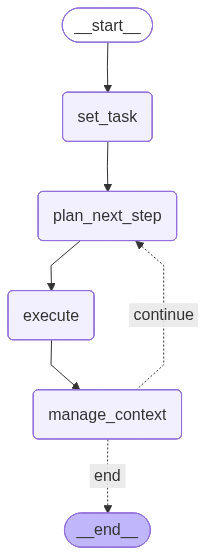

In [4]:
import json
from generalist.agents.core import AgentDeepWebSearch, AgentUnstructuredDataProcessor, AgentCodeWriterExecutor
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer, summarise_findings
from langgraph.graph import StateGraph, START, END


def init_state(ask: str, resources: list[Message] | None = None) -> ExecutionState:
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context=[],
        answers=list(),
        resource=resources if resources else [],
    )

def set_task(state: ExecutionState) -> ExecutionState:
    question_task = state["ask"]
    task_plan_response = create_plan(question_task)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    identified_resource = result.get("resource", None)
    task_msg = Message(
        provided_by="User",
        content=str(task),
        metadata={},
    )
    if identified_resource:
        task_msg.link = identified_resource.get("link", None)

    state["resource"] = task_msg
    state["task"] = task

    state["step"] = 0
    return state

def plan_next_step(state: ExecutionState) -> ExecutionState:
    # Automatically determine which step to execute based on context
    capability_plan_json = determine_capabilities(
        task=str(state["task"].plan),
        resource=str(state["resource"]),
        context=str(state["answers"]),
    )

    state["capability_plan"] = AgentPlan.from_json(capability_plan_json)
    return state

def execute(state: ExecutionState) -> ExecutionState:
    capability = state["capability_plan"].agent
    activity = state["capability_plan"].activity
    output_resource = Message(activity, "")
    capability_agent = capability(activity)
    if capability is AgentDeepWebSearch:
        output_resource = capability_agent.run()
    elif capability is AgentUnstructuredDataProcessor:
        output_resource = capability_agent.run([state["resource"]])
    elif capability is AgentCodeWriterExecutor:
        output_resource = capability_agent.run([state["resource"]])
    else:
        print("DEBUG | run_capability | Call to unidentified agent: ", capability)

    # TODO: allow to process multiple resources at a time, for now only one
    if output_resource:
        state["resource"] = output_resource
        # Update context with step results
        # state["context"] = f"Step {capability_agent.name} produced: {output_resource}"
    else:
        raise ValueError("Should always produce a resource")

    state["context"].append(output_resource)
    state["step"] += 1

    return state

def manage_context(state: ExecutionState) -> ExecutionState:
    """
    Summarise what has been found and decide what we need to keep in the context.
    """
    short_answer = summarise_findings(
        state["capability_plan"].activity,
        str(state["context"]),
    )

    state["answers"] = [short_answer]

    return state

def evaluate_task_completion(state: ExecutionState) -> str:
    # We have agents from which we do not expect an answer, they just search
    # TODO: Duplicate code with `manage_context`, unify
    if state["capability_plan"].agent in [AgentDeepWebSearch]:
        short_answer = ShortAnswer(answered=False, answer="", clarification="it was search")
    else:
        short_answer = construct_short_answer(
            str(state["task"]),
            str(state["answers"])
        )

    # Early stopping if answer exists
    if short_answer.answered:
        return "end"

    # Early stopping if maximum number of steps reached
    if state['step'] >= MAX_STEPS:
        return "end"

    return "continue"


workflow = StateGraph(state_schema=ExecutionState)

workflow.add_node("set_task", set_task)
workflow.add_node("plan_next_step", plan_next_step)
workflow.add_node("execute", execute)
workflow.add_node("manage_context", manage_context)

workflow.add_edge(START, "set_task")
workflow.add_edge("set_task", "plan_next_step")
workflow.add_edge("plan_next_step", "execute")
workflow.add_edge("execute", "manage_context")
workflow.add_conditional_edges(
    "manage_context",
    evaluate_task_completion,
    {
        "continue": "plan_next_step",
        "end": END,
    }
)

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [5]:
import os
import logging
from dotenv import load_dotenv

import mlflow
from huggingface_hub import snapshot_download
from datasets import load_dataset


logging.getLogger().setLevel(logging.INFO)
load_dotenv()


gaia_path = os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH")
data_dir = snapshot_download(local_dir=gaia_path,  local_files_only=True, repo_id="gaia-benchmark/GAIA", repo_type="dataset")

dataset = load_dataset(data_dir, "2023_level1", split="validation")
gaia_keys = ['task_id', 'Question', 'Level', 'Final answer', 'file_name', 'file_path', 'Annotator Metadata']

sosa_many_studio_albums_task_id = "8e867cd7-cff9-4e6c-867a-ff5ddc2550be" # web search
running_to_the_moon_task_id = "e1fc63a2-da7a-432f-be78-7c4a95598703"  # web search + calculating
dr_who_season_9_eps_11_location_task_id = "4b6bb5f7-f634-410e-815d-e673ab7f8632" # web search and pdf reading
calc_sales_xlsx_task_id = "7bd855d8-463d-4ed5-93ca-5fe35145f733"
just_running_python_task_id = "f918266a-b3e0-4914-865d-4faa564f1aef"
looking_up_paper_authors_task_id = "46719c30-f4c3-4cad-be07-d5cb21eee6bb" # web search + possibly pdf reading from online
dinosaur_article_task_id = "4fc2f1ae-8625-45b5-ab34-ad4433bc21f8" # web search
merriam_webster_word_task_id = "5188369a-3bbe-43d8-8b94-11558f909a08" # web search
reading_txt_and_solving_puzzle_task_id = "389793a7-ca17-4e82-81cb-2b3a2391b4b9"
teal_video_task_id = "9d191bce-651d-4746-be2d-7ef8ecadb9c2"
very_specific_web_search_download_task_id = "cabe07ed-9eca-40ea-8ead-410ef5e83f91"
listening_to_recipe_task_id = "99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3" # audio processing
scikit_learn_change_log_task_id = "d0633230-7067-47a9-9dbf-ee11e0a2cdd6" # web search + code processing
polish_raymond_task_id = "305ac316-eef6-4446-960a-92d80d542f82"
baseball_table_processing_task_id = "3f57289b-8c60-48be-bd80-01f8099ca449" # web search + online table processing
audio_processing_homework_task_id = "1f975693-876d-457b-a649-393859e79bf3"
multistep_browser_search_on_a_website_task_id = "a0068077-79f4-461a-adfe-75c1a4148545"
kuznetsov_paper_st_petersburg_task_id = "bda648d7-d618-4883-88f4-3466eabd860e" # web search + pdf analysis
country_with_list_medals_task_id = "cf106601-ab4f-4af9-b045-5295fe67b37d" # web search + small table processing
country_no_longer_exists_web_search_task_id = "5a0c1adf-205e-4841-a666-7c3ef95def9d"

evaluation_tasks = [
    # just_running_python_task_id,
    # sosa_many_studio_albums_task_id,
    # calc_sales_xlsx_task_id,
    # running_to_the_moon_task_id,

    # merriam_webster_word_task_id,
    # looking_up_paper_authors_task_id,

    # baseball_table_processing_task_id,
    # just_browser_search_task_id,

    country_with_list_medals_task_id,
    # polish_raymond_task_id
]

results = []
dataset_questions = { sample["task_id"]:sample for sample in dataset }
for sample_task_id in evaluation_tasks:
    sample = dataset_questions[sample_task_id]
    [ print(k, "=", sample[k]) for k in gaia_keys ]

    mlflow.langchain.autolog()                                               # this is needed to register traces within the experiment
    experiment_name = f"gaia_{"_".join(sample["task_id"].split("-"))}"
    mlflow.set_experiment(experiment_name)
    mlflow.models.set_model(generalist_graph)
    logging.getLogger().setLevel(logging.INFO)

    experiment_url = mlflow.get_experiment_by_name(experiment_name)
    # mlflow.set_tracking_uri('http://localhost:5000')

    question = sample["Question"]
    resources = []
    if sample["file_path"]:
        resource = Message(
            provided_by="user",
            content="file provided with the main task",
            link=os.path.join(os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH"), sample["file_path"]),
            metadata={"note":"the file is already in the list of available resources"}
        )
        print(resource.link)
        resources.append(resource)
    initial_state = init_state(question, resources=resources)
    final_state = generalist_graph.invoke(initial_state)
    answers = final_state["answers"]
    results.append((sample, {"answers":answers, "experiment_url": experiment_url}))

Returning existing local_dir `/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia` as remote repo cannot be accessed in `snapshot_download` (None).


task_id = cf106601-ab4f-4af9-b045-5295fe67b37d
Question = What country had the least number of athletes at the 1928 Summer Olympics? If there's a tie for a number of athletes, return the first in alphabetical order. Give the IOC country code as your answer.
Level = 1
Final answer = CUB
file_name = 
file_path = 
Annotator Metadata = {'Steps': '1. Look up the 1928 Summer Olympics on Wikipedia\n2. Look at a table of athletes from countries.\n3. See that two countries had 1 and 2 athletes, so disregard those and choose the Cuba as CUB.', 'Number of steps': '3', 'How long did this take?': '5 minutes', 'Tools': 'None', 'Number of tools': '0'}


2026-02-06 18:16:09,725 - generalist.tools.planning - determine_capabilities:154 - INFO - Raw output: {
  "activity": "Retrieve the list of countries and their corresponding IOC country codes from the Wikipedia page on the 1928 Summer Olympics available at https://en.wikipedia.org/wiki/1928_Summer_Olympics",
  "agent": "deep_web_search"
}
2026-02-06 18:16:17,398 - generalist.agents.core - run:78 - INFO -  After running deep_web_search, the final state is:
{'task': 'Retrieve the list of countries and their corresponding IOC country codes from the Wikipedia page on the 1928 Summer Olympics available at https://en.wikipedia.org/wiki/1928_Summer_Olympics', 'context': [Message(provided_by='web_search', content='Web search SUCCESSFUL for task: Retrieve the list of countries and their corresponding IOC country codes from the Wikipedia page on the 1928 Summer Olympics available at https://en.wikipedia.org/wiki/1928_Summer_Olympics. The downloaded info is stored in /var/folders/f6/6mkw37fs20q07

chunks ["Encountered error: web_search() got an unexpected keyword argument 'urls_to_search'"]
chunk Encountered error: web_search() got an unexpected keyword argument 'urls_to_search'
[]


2026-02-06 18:17:25,231 - generalist.tools.summarisers - summarise_findings:125 - INFO - From `summarise_findings`:
Based on the provided information, a web search was conducted successfully to retrieve the list of countries and their corresponding International Olympic Committee (IOC) country codes from the Wikipedia page dedicated to the 1928 Summer Olympics. The relevant data has been downloaded and is stored at the path `/var/folders/f6/6mkw37fs20q07p9x11q7d7k80000gq/T/tmp8r5pp89n`. 

Subsequently, there was an instruction to process this unstructured text data from the specified file path. However, no specific content or results have been provided regarding the processing and summarization of that information.

The task at hand is to extract and summarize the list of countries along with their corresponding IOC country codes as they were participating in the 1928 Summer Olympics. For this step, detailed extraction from the file located at `/var/folders/f6/6mkw37fs20q07p9x11q7d7k80

In [6]:
[ print(r[0]["Question"],"----->", r[0]["Final answer"],"\n", r[1]["answers"], "\n") for r in results ]

What country had the least number of athletes at the 1928 Summer Olympics? If there's a tie for a number of athletes, return the first in alphabetical order. Give the IOC country code as your answer. -----> CUB 
 [ShortAnswer(answered=False, answer='this is just a summary of previous steps.', clarification='Based on the provided information, here is a summary detailing what was achieved and found:\n\n### Achievements:\n- A web search has been successfully conducted to retrieve the necessary data from the Wikipedia page on the 1928 Summer Olympics. The results of this search are stored in `/var/folders/f6/6mkw37fs20q07p9x11q7d7k80000gq/T/tmp8r5pp89n`.\n- Multiple attempts have been made to process the unstructured data located at `/var/folders/f6/6mkw37fs20q07p9x11q7d7k80000gq/T/tmp8r5pp89n` in order to extract and summarize a list of countries along with their corresponding IOC country codes for the 1928 Summer Olympics.\n\n### Findings:\n- The processing attempts have not resulted in 

[None]

NameError: name 'false' is not defined